In [2]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib import cm
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
dde.config.set_default_float("float64")

Num GPUs Available:  1
Set the default float type to float64


In [11]:
t0 = time()
geom= dde.geometry.Interval(0,2*np.pi)
timedomain = dde.geometry.TimeDomain(0,5)
geotime = dde.geometry.GeometryXTime(geom,timedomain)

def pde(x,y):
    dy_x = dde.grad.jacobian(y,x,i=0,j=0)
    dy_t = dde.grad.jacobian(y,x,i=0,j=1)
    dy_xx = dde.grad.hessian(y,x,i=0,j=0)
    return dy_t + y*dy_x - 0.01*dy_xx - tf.sin(x[:,0:1])

bc = dde.icbc.DirichletBC(geotime,lambda x: 0, lambda _,on_boundary:on_boundary)
ic = dde.icbc.IC(geotime,lambda x:np.sin(x[:,0:1]),lambda _,on_initial:on_initial)

data = dde.data.TimePDE(geotime,pde,[bc,ic],num_domain=30000,num_boundary=500,num_initial=1000)

net = dde.nn.FNN([2]+[50]*4+[1],'tanh','Glorot normal')

model5 = dde.Model(data,net)
model5.compile("adam", lr=1e-3)
print("learning rate = ",1e-3)
model5.train(iterations=15000)
model5.compile("L-BFGS")
losshistory, train_state = model5.train()
t1 = time()
print("Total time taken:",t1-t0,"sec")

Compiling model...
Building feed-forward neural network...
'build' took 0.055463 s



2023-04-22 12:21:02.307524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78977 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


'compile' took 0.862693 s

learning rate =  0.001
Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.74e-01, 4.19e-01, 1.24e+00]    [5.74e-01, 4.19e-01, 1.24e+00]    []  
1000      [2.67e-01, 5.84e-04, 3.31e-02]    [2.67e-01, 5.84e-04, 3.31e-02]    []  
2000      [2.47e-01, 8.09e-05, 2.64e-02]    [2.47e-01, 8.09e-05, 2.64e-02]    []  
3000      [1.54e-01, 2.90e-04, 2.02e-02]    [1.54e-01, 2.90e-04, 2.02e-02]    []  
4000      [4.81e-02, 2.89e-04, 4.40e-03]    [4.81e-02, 2.89e-04, 4.40e-03]    []  
5000      [1.32e-02, 2.01e-04, 1.80e-03]    [1.32e-02, 2.01e-04, 1.80e-03]    []  
6000      [5.13e-03, 6.39e-05, 4.83e-04]    [5.13e-03, 6.39e-05, 4.83e-04]    []  
7000      [6.18e-03, 3.60e-05, 8.27e-04]    [6.18e-03, 3.60e-05, 8.27e-04]    []  
8000      [1.74e-03, 2.35e-05, 1.60e-04]    [1.74e-03, 2.35e-05, 1.60e-04]    []  
9000      [1.18e-03, 1.34e-05, 7.37e-05]    [1.18e-03, 1.34e-05, 7.3

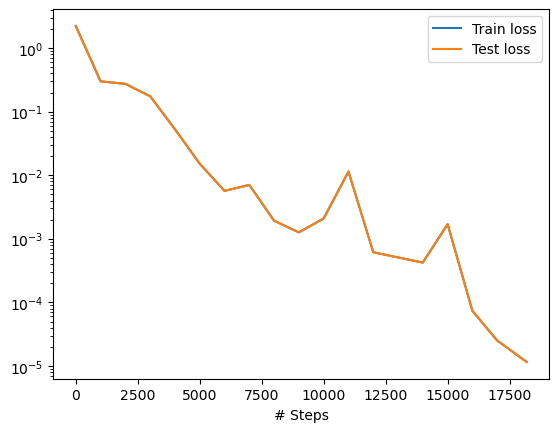

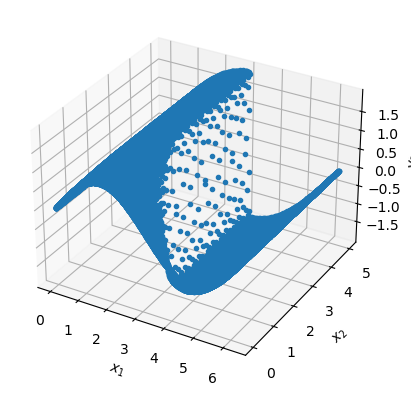

In [12]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

Resampling State: 1
Compiling model...
'compile' took 0.618250 s



2023-04-22 12:23:37.293358: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_3/Assign' id:25138 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_3/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_3, dense_9/bias/Adam_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...



KeyboardInterrupt: 

Text(0.5, 1.0, '$\\nu$=0.01')

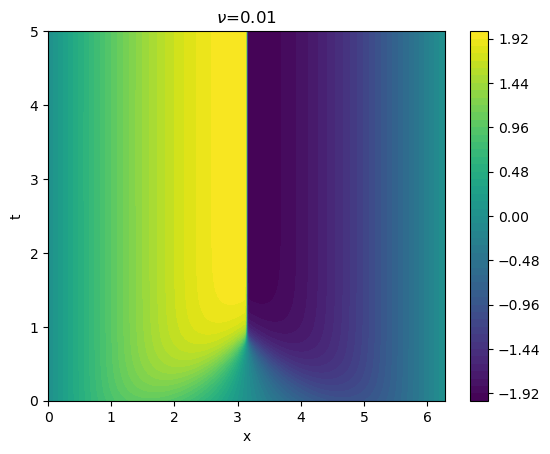

In [14]:
t=np.linspace(0.0,5.0,1000)
x=np.linspace(0.0,2*np.pi,1000)
xx, tt = np.meshgrid(x, t)
X=np.concatenate([xx.reshape(1000,1000,1),tt.reshape(1000,1000,1)],axis=2)
f1 = model5.predict(X.reshape((1000000,2)))
s=plt.contourf(xx,tt,f1.reshape(1000,1000),50)
plt.colorbar(s)
plt.xlabel("x")
plt.ylabel("t")
plt.title(r"$\nu$=0.01")

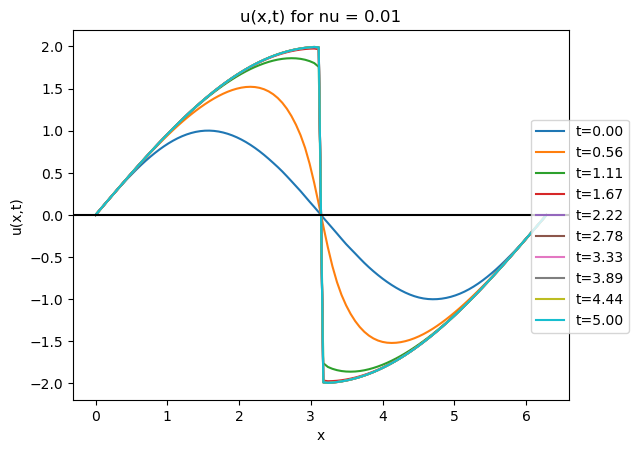

In [16]:
number_of_plots = 10
t1 = np.linspace(0,5,number_of_plots)

fig=plt.figure(1)#,figsize=(10,8)
x = np.linspace(0,2*np.pi,100)
#fig,axes = plt.subplots(number_of_plots,figsize=(6,number_of_plots*6))
for i in range(number_of_plots):
    
    t = t1[i] * np.ones_like(x)
    X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
    z = model5.predict(X_T)
    plt.plot(x,z,label="t=%.2f"%(t1[i]))
    
plt.axhline(y=0,xmin=0.0,xmax=2*np.pi,c="black")
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("u(x,t) for nu = 0.01")
fig.legend(loc='outside right')

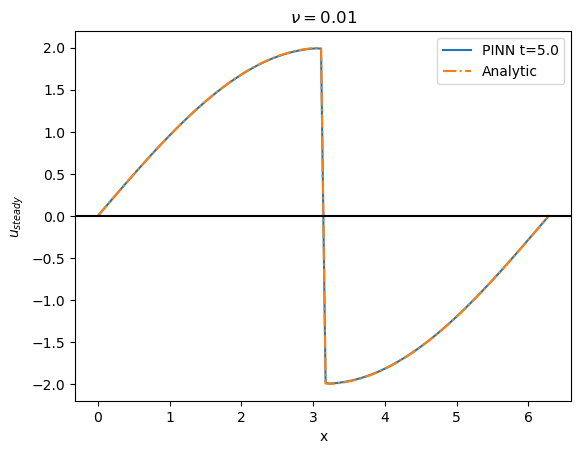

In [21]:
def sgn(x):
    out = []
    for i in x:
        if i<0:
            out.append(1.0)
        else:
            out.append(-1.0)
    return np.array(out)


def u(x,nu):
    return 2*sgn(x-np.pi)*(np.sin(x/2)-1) +2*np.tanh((np.pi-x)/nu)

x = np.linspace(0,2*np.pi,100)
t = 5.0 * np.ones_like(x)
X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
z = model5.predict(X_T)
plt.plot(x,z,label="PINN t=5.0")
u_0_01 = u(x,0.01)
plt.plot(x,u_0_01,'-.',label='Analytic')
plt.axhline(y=0,xmin=0.0,xmax=2*np.pi,c="black")

plt.xlabel('x')
plt.ylabel('$u_{steady}$')
plt.title(r'$\nu =0.01$')
plt.legend()

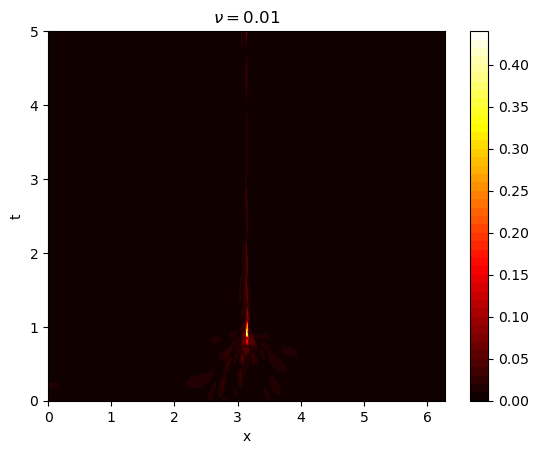

In [15]:
plt.figure(2)#,figsize=(12,10))
t=np.linspace(0,5,1000)
x=np.linspace(0,2*np.pi,1000)
xx, tt = np.meshgrid(x, t)

X=np.concatenate([xx.reshape(1000,1000,1),tt.reshape(1000,1000,1)],axis=2)
f1 = np.abs(model5.predict(X.reshape((1000000,2)),operator=pde))

s=plt.contourf(xx,tt,f1.reshape(1000,1000),50)
cmap = plt.get_cmap('hot')
plt.set_cmap(cmap)
plt.colorbar()
#plt.savefig('R10911.png')
plt.xlabel('x')
plt.ylabel('t')
plt.title(r'$\nu=0.01$')
plt.show()

In [22]:
dde.optimizers.config.set_LBFGS_options(maxiter=5000)
k = 1.3
c = 1
for i in range(10):
    print("Resampling State:",i+1)
    X = geotime.random_points(150000)
    Y = np.abs(model5.predict(X, operator=pde)).astype(np.float64)
    err_eq = np.power(Y, k) / np.power(Y, k).mean() + c
    err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
    X_ids = np.random.choice(a=len(X), size=30000, replace=False, p=err_eq_normalized)
    X_selected = X[X_ids]
    data.replace_with_anchors(X_selected)

    model5.compile("adam", lr=0.001)
    model5.train(epochs=1000)
    model5.compile("L-BFGS")
    losshistory, train_state = model5.train()



Resampling State: 1
Compiling model...
'compile' took 1.613366 s



2023-04-22 12:34:07.139603: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_5/Assign' id:26402 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_5/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_5, dense_9/bias/Adam_5/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
18190     [7.07e-05, 1.02e-07, 7.02e-07]    [1.08e-05, 1.02e-07, 7.02e-07]    []  
19000     [4.09e-03, 1.86e-05, 2.00e-03]    [2.95e-03, 1.86e-05, 2.00e-03]    []  
19190     [7.13e-04, 1.20e-06, 1.36e-04]    [6.14e-04, 1.20e-06, 1.36e-04]    []  

Best model at step 18190:
  train loss: 1.16e-05
  test loss: 1.16e-05
  test metric: []

'train' took 10.296332 s

Compiling model...
'compile' took 0.572877 s

Training model...

Step      Train loss                        Test loss                         Test metric
19190     [7.13e-04, 1.20e-06, 1.36e-04]    [6.14e-04, 1.20e-06, 1.36e-04]    []  
20000     [3.28e-05, 7.84e-08, 2.62e-06]    [3.28e-05, 7.84e-08, 2.62e-06]        
21000     [2.14e-05, 1.10e-07, 2.26e-06]    [2.14e-05, 1.10e-07, 2.26e-06]        
22000     [1.47e-05, 1.01e-07, 1.50e-06]    [1.47e-05, 1.01e-07, 1.50e-06]        
23000     [1.04e-05, 1.13e-07, 9.89e-0

2023-04-22 12:36:25.377594: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_7/Assign' id:28725 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_7/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_7, dense_9/bias/Adam_7/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
24664     [1.18e-05, 5.55e-08, 6.62e-07]    [5.00e-06, 5.55e-08, 6.62e-07]    []  
25000     [5.72e-03, 8.73e-06, 3.69e-03]    [3.66e-03, 8.73e-06, 3.69e-03]    []  
25664     [2.99e-04, 4.55e-07, 6.53e-05]    [2.29e-04, 4.55e-07, 6.53e-05]    []  

Best model at step 24664:
  train loss: 7.24e-06
  test loss: 5.72e-06
  test metric: []

'train' took 10.173917 s

Compiling model...
'compile' took 0.597127 s

Training model...

Step      Train loss                        Test loss                         Test metric
25664     [2.99e-04, 4.55e-07, 6.53e-05]    [2.29e-04, 4.55e-07, 6.53e-05]    []  
26000     [1.17e-05, 1.18e-07, 7.86e-07]    [1.17e-05, 1.18e-07, 7.86e-07]        
27000     [7.22e-06, 6.57e-08, 5.07e-07]    [7.22e-06, 6.57e-08, 5.07e-07]        
28000     [5.55e-06, 6.84e-08, 4.24e-07]    [5.55e-06, 6.84e-08, 4.24e-07]        
29000     [4.71e-06, 4.92e-08, 2.76e-0

2023-04-22 12:38:36.107947: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_9/Assign' id:31092 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_9/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_9, dense_9/bias/Adam_9/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
31143     [5.16e-06, 2.82e-08, 1.41e-07]    [2.04e-06, 2.82e-08, 1.41e-07]    []  
32000     [2.39e-04, 4.42e-07, 6.44e-05]    [1.95e-04, 4.42e-07, 6.44e-05]    []  
32143     [1.71e-04, 3.06e-07, 3.85e-05]    [1.41e-04, 3.06e-07, 3.85e-05]    []  

Best model at step 31143:
  train loss: 3.06e-06
  test loss: 2.21e-06
  test metric: []

'train' took 11.286359 s

Compiling model...
'compile' took 0.597304 s

Training model...

Step      Train loss                        Test loss                         Test metric
32143     [1.71e-04, 3.06e-07, 3.85e-05]    [1.41e-04, 3.06e-07, 3.85e-05]    []  
33000     [3.94e-06, 3.29e-08, 1.52e-07]    [3.94e-06, 3.29e-08, 1.52e-07]        
34000     [2.96e-06, 4.22e-08, 1.70e-07]    [2.96e-06, 4.22e-08, 1.70e-07]        
35000     [2.53e-06, 3.30e-08, 1.49e-07]    [2.53e-06, 3.30e-08, 1.49e-07]        
36000     [2.27e-06, 3.09e-08, 1.10e-0

2023-04-22 12:41:16.570203: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_11/Assign' id:33503 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_11/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_11, dense_9/bias/Adam_11/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
37663     [3.20e-06, 2.48e-08, 1.06e-07]    [1.40e-06, 2.48e-08, 1.06e-07]    []  
38000     [3.18e-03, 8.42e-06, 1.30e-03]    [2.48e-03, 8.42e-06, 1.30e-03]    []  
38663     [2.69e-04, 4.85e-07, 2.87e-05]    [2.53e-04, 4.85e-07, 2.87e-05]    []  

Best model at step 37663:
  train loss: 2.12e-06
  test loss: 1.53e-06
  test metric: []

'train' took 11.181897 s

Compiling model...
'compile' took 0.690253 s

Training model...

Step      Train loss                        Test loss                         Test metric
38663     [2.69e-04, 4.85e-07, 2.87e-05]    [2.53e-04, 4.85e-07, 2.87e-05]    []  
39000     [4.40e-06, 5.55e-08, 2.43e-07]    [4.40e-06, 5.55e-08, 2.43e-07]        
40000     [2.40e-06, 2.72e-08, 1.25e-07]    [2.40e-06, 2.72e-08, 1.25e-07]        
41000     [2.09e-06, 2.68e-08, 9.69e-08]    [2.09e-06, 2.68e-08, 9.69e-08]        
42000     [1.86e-06, 1.90e-08, 8.39e-0

2023-04-22 12:43:25.685828: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_13/Assign' id:35958 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_13/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_13, dense_9/bias/Adam_13/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
44145     [2.62e-06, 1.63e-08, 7.33e-08]    [1.19e-06, 1.63e-08, 7.33e-08]    []  
45000     [2.96e-04, 8.21e-07, 6.97e-05]    [2.57e-04, 8.21e-07, 6.97e-05]    []  
45145     [1.87e-04, 4.99e-07, 2.91e-05]    [1.70e-04, 4.99e-07, 2.91e-05]    []  

Best model at step 44145:
  train loss: 1.65e-06
  test loss: 1.28e-06
  test metric: []

'train' took 12.193342 s

Compiling model...
'compile' took 0.624700 s

Training model...

Step      Train loss                        Test loss                         Test metric
45145     [1.87e-04, 4.99e-07, 2.91e-05]    [1.70e-04, 4.99e-07, 2.91e-05]    []  
46000     [2.06e-06, 2.34e-08, 9.76e-08]    [2.06e-06, 2.34e-08, 9.76e-08]        
47000     [1.65e-06, 1.69e-08, 8.18e-08]    [1.65e-06, 1.69e-08, 8.18e-08]        
48000     [1.48e-06, 1.82e-08, 6.62e-08]    [1.48e-06, 1.82e-08, 6.62e-08]        
49000     [1.37e-06, 1.16e-08, 6.23e-0

2023-04-22 12:45:36.710308: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_15/Assign' id:38457 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_15/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_15, dense_9/bias/Adam_15/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
50696     [2.11e-06, 1.27e-08, 6.19e-08]    [8.07e-07, 1.27e-08, 6.19e-08]    []  
51000     [1.18e-02, 2.21e-05, 7.64e-03]    [8.55e-03, 2.21e-05, 7.64e-03]    []  
51696     [1.25e-03, 6.68e-07, 4.05e-04]    [1.02e-03, 6.68e-07, 4.05e-04]    []  

Best model at step 50696:
  train loss: 1.33e-06
  test loss: 8.82e-07
  test metric: []

'train' took 11.101887 s

Compiling model...
'compile' took 0.621146 s

Training model...

Step      Train loss                        Test loss                         Test metric
51696     [1.25e-03, 6.68e-07, 4.05e-04]    [1.02e-03, 6.68e-07, 4.05e-04]    []  
52000     [7.81e-06, 1.80e-07, 4.37e-07]    [7.81e-06, 1.80e-07, 4.37e-07]        
53000     [2.10e-06, 2.13e-08, 8.92e-08]    [2.10e-06, 2.13e-08, 8.92e-08]        
54000     [1.71e-06, 1.85e-08, 7.01e-08]    [1.71e-06, 1.85e-08, 7.01e-08]        
55000     [1.52e-06, 1.29e-08, 6.94e-0

2023-04-22 12:47:49.888346: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_17/Assign' id:41000 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_17/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_17, dense_9/bias/Adam_17/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
57214     [1.85e-06, 1.22e-08, 6.56e-08]    [7.51e-07, 1.22e-08, 6.56e-08]    []  
58000     [2.23e-03, 2.78e-06, 4.78e-04]    [1.99e-03, 2.78e-06, 4.78e-04]    []  
58214     [1.48e-03, 1.57e-06, 2.13e-04]    [1.38e-03, 1.57e-06, 2.13e-04]    []  

Best model at step 50696:
  train loss: 1.33e-06
  test loss: 8.82e-07
  test metric: []

'train' took 11.317658 s

Compiling model...
'compile' took 0.708046 s

Training model...

Step      Train loss                        Test loss                         Test metric
58214     [1.48e-03, 1.57e-06, 2.13e-04]    [1.38e-03, 1.57e-06, 2.13e-04]    []  
59000     [2.66e-06, 4.19e-08, 1.32e-07]    [2.66e-06, 4.19e-08, 1.32e-07]        
60000     [1.55e-06, 1.76e-08, 9.73e-08]    [1.55e-06, 1.76e-08, 9.73e-08]        
61000     [1.39e-06, 1.42e-08, 7.41e-08]    [1.39e-06, 1.42e-08, 7.41e-08]        
62000     [1.28e-06, 1.38e-08, 6.45e-0

2023-04-22 12:50:11.827175: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_19/Assign' id:43587 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_19/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_19, dense_9/bias/Adam_19/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
63719     [1.80e-06, 1.05e-08, 6.32e-08]    [6.12e-07, 1.05e-08, 6.32e-08]    []  
64000     [8.42e-03, 1.60e-05, 5.78e-03]    [5.75e-03, 1.60e-05, 5.78e-03]    []  
64719     [1.16e-03, 8.85e-07, 4.74e-04]    [9.24e-04, 8.85e-07, 4.74e-04]    []  

Best model at step 63719:
  train loss: 1.22e-06
  test loss: 6.86e-07
  test metric: []

'train' took 11.458469 s

Compiling model...
'compile' took 0.660958 s

Training model...

Step      Train loss                        Test loss                         Test metric
64719     [1.16e-03, 8.85e-07, 4.74e-04]    [9.24e-04, 8.85e-07, 4.74e-04]    []  
65000     [7.66e-06, 2.67e-07, 5.39e-07]    [7.66e-06, 2.67e-07, 5.39e-07]        
66000     [1.81e-06, 1.90e-08, 9.18e-08]    [1.81e-06, 1.90e-08, 9.18e-08]        
67000     [1.42e-06, 1.06e-08, 7.26e-08]    [1.42e-06, 1.06e-08, 7.26e-08]        
68000     [1.24e-06, 1.25e-08, 6.31e-0

2023-04-22 12:52:46.855100: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_21/Assign' id:46218 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_21/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_21, dense_9/bias/Adam_21/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
70212     [1.60e-06, 1.04e-08, 5.47e-08]    [6.36e-07, 1.04e-08, 5.47e-08]    []  
71000     [1.46e-03, 6.76e-07, 5.17e-04]    [1.18e-03, 6.76e-07, 5.17e-04]    []  
71212     [6.33e-04, 6.71e-07, 1.46e-04]    [5.20e-04, 6.71e-07, 1.46e-04]    []  

Best model at step 70212:
  train loss: 1.13e-06
  test loss: 7.01e-07
  test metric: []

'train' took 11.351215 s

Compiling model...
'compile' took 0.752516 s

Training model...

Step      Train loss                        Test loss                         Test metric
71212     [6.33e-04, 6.71e-07, 1.46e-04]    [5.20e-04, 6.71e-07, 1.46e-04]    []  
72000     [2.43e-06, 2.27e-08, 1.08e-07]    [2.43e-06, 2.27e-08, 1.08e-07]        
73000     [1.45e-06, 1.23e-08, 7.88e-08]    [1.45e-06, 1.23e-08, 7.88e-08]        
74000     [1.26e-06, 1.25e-08, 7.35e-08]    [1.26e-06, 1.25e-08, 7.35e-08]        
75000     [1.16e-06, 1.33e-08, 6.24e-0

2023-04-22 12:55:28.866511: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_9/bias/Adam_23/Assign' id:48893 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_23/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_23, dense_9/bias/Adam_23/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training model...

Step      Train loss                        Test loss                         Test metric
76725     [1.44e-06, 9.34e-09, 5.80e-08]    [5.65e-07, 9.34e-09, 5.80e-08]    []  
77000     [1.62e-03, 9.61e-06, 6.30e-04]    [1.29e-03, 9.61e-06, 6.30e-04]    []  
77725     [3.82e-05, 2.81e-07, 2.49e-06]    [2.81e-05, 2.81e-07, 2.49e-06]    []  

Best model at step 76725:
  train loss: 1.12e-06
  test loss: 6.32e-07
  test metric: []

'train' took 11.286034 s

Compiling model...
'compile' took 0.667114 s

Training model...

Step      Train loss                        Test loss                         Test metric
77725     [3.82e-05, 2.81e-07, 2.49e-06]    [2.81e-05, 2.81e-07, 2.49e-06]    []  
78000     [4.14e-06, 8.69e-08, 1.50e-07]    [4.14e-06, 8.69e-08, 1.50e-07]        
79000     [1.44e-06, 1.77e-08, 5.92e-08]    [1.44e-06, 1.77e-08, 5.92e-08]        
80000     [1.14e-06, 1.15e-08, 6.15e-08]    [1.14e-06, 1.15e-08, 6.15e-08]        
81000     [1.04e-06, 1.15e-08, 5.23e-0

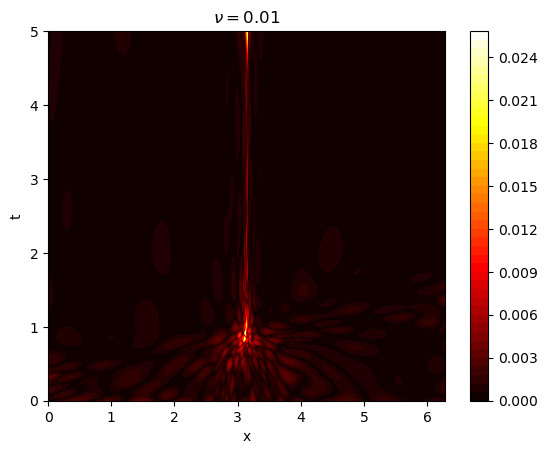

In [23]:
plt.figure(2)#,figsize=(12,10))
t=np.linspace(0,5,1000)
x=np.linspace(0,2*np.pi,1000)
xx, tt = np.meshgrid(x, t)

X=np.concatenate([xx.reshape(1000,1000,1),tt.reshape(1000,1000,1)],axis=2)
f1 = np.abs(model5.predict(X.reshape((1000000,2)),operator=pde))

s=plt.contourf(xx,tt,f1.reshape(1000,1000),50)
cmap = plt.get_cmap('hot')
plt.set_cmap(cmap)
plt.colorbar()
#plt.savefig('R10911.png')
plt.xlabel('x')
plt.ylabel('t')
plt.title(r'$\nu=0.01$')
plt.show()

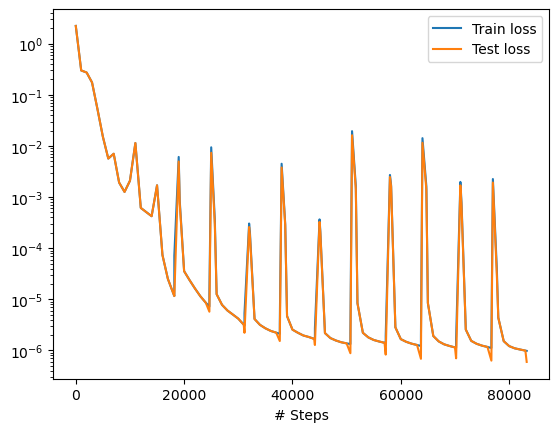

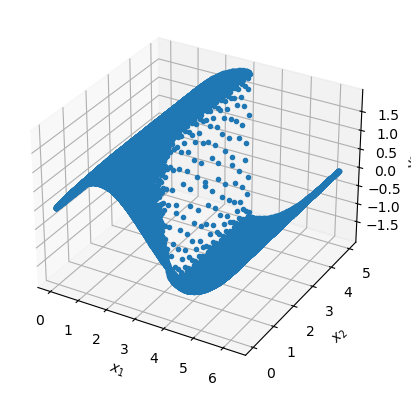

In [24]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)